
<center>
<font color="cyan"><h2 > Streaming</h2></font>
<center>
<h3>Stream Response</h3>
<ul>
</ul>
</center>
</center>



### Summarize of chat using ChatGPT

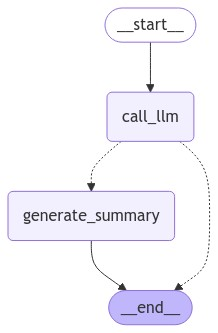

In [6]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START,END,StateGraph,MessagesState
from dotenv import load_dotenv
from IPython.display import display,Image
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
path = 'summarize.db'
conm = sqlite3.connect(path,check_same_thread=False)
memory = SqliteSaver(conm)
load_dotenv()

llm = ChatOpenAI(model='gpt-4o-mini')

class State(MessagesState):
    summary : str
    
    
def call_llm(state):
    response = llm.invoke(state['messages'])
    return {'messages' : response}

def generate_summary(state):
    prev_summary = state.get('summary','')
    if prev_summary:
        summary = f"This is the previous summary {prev_summary}. Update the summary with the latest chat."
    else:
        summary = "Create the summary of the previous chat."
    message = state['messages']+[HumanMessage(content=summary)]
    response = llm.invoke(message)
    return {'summary': response.content,'messages':state['messages']}

def conditional_call(state):
    if len(state['messages']) > 3:
        return 'generate_summary'
    return END


builder = StateGraph(State)

builder.add_node('call_llm',call_llm)
builder.add_node('generate_summary',generate_summary)

builder.add_edge(START,'call_llm')
builder.add_conditional_edges('call_llm',conditional_call)
builder.add_edge('generate_summary',END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [7]:
config = {'configurable':{'thread_id':1}}
response = graph.invoke({'messages':"Hey I name is aditya."},config=config)

In [8]:
response

{'messages': [HumanMessage(content='Hey I name is aditya.', additional_kwargs={}, response_metadata={}, id='942f4d64-5874-46b5-86f2-f0db621e0827'),
  HumanMessage(content='Hey I name is aditya.', additional_kwargs={}, response_metadata={}, id='f45fa66e-baab-49d9-a915-28beb2e443a2'),
  AIMessage(content='Hi Aditya! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 25, 'total_tokens': 36, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b78b61c52', 'finish_reason': 'stop', 'logprobs': None}, id='run-79b9ba26-2cdc-464c-a7ab-c4b2d0e39a15-0', usage_metadata={'input_tokens': 25, 'output_tokens': 11, 'total_tokens': 36, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output

In [9]:
graph.invoke({'messages':"What is my name"},config=config)

{'messages': [HumanMessage(content='Hey I name is aditya.', additional_kwargs={}, response_metadata={}, id='942f4d64-5874-46b5-86f2-f0db621e0827'),
  HumanMessage(content='Hey I name is aditya.', additional_kwargs={}, response_metadata={}, id='f45fa66e-baab-49d9-a915-28beb2e443a2'),
  AIMessage(content='Hi Aditya! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 25, 'total_tokens': 36, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b78b61c52', 'finish_reason': 'stop', 'logprobs': None}, id='run-79b9ba26-2cdc-464c-a7ab-c4b2d0e39a15-0', usage_metadata={'input_tokens': 25, 'output_tokens': 11, 'total_tokens': 36, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output

## stream and astream demo